In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [1]:
import sys
sys.path.append('../../')

In [2]:
from codes.docs.analysis import data_preprocessing, logging_outputs

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import scipy.io
%matplotlib inline

# 1. Data Preprocessing and Importing

In [14]:
full_dataset=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='allSubjectsWithKANA_AALVolumes').drop('ID',axis=1)
full_dataset=full_dataset.rename({'Subject':'ID'},axis=1)
full_dataset.rename(columns={'GA at birth':'GA','PMA at birth':'PMA'},inplace=True)
full_dataset=full_dataset.sort_values(by='Session',ascending=False)
full_dataset=full_dataset.drop_duplicates(subset='ID',keep='last')
full_dataset=full_dataset.reset_index(drop=True)

In [15]:
print('volumetric dataset')
full_dataset.head(5)

volumetric dataset


,ID,Session,GA,PMA,17 ICV (all except bone),17 TOTAL BRAIN TISSUE VOLUME (mm3),"19 Volume Pallidum (Bilateral) AAL, careful with preterm","28 Volume Mesencephalon (right cerebellum) (AAL, careful with preterm!)","28 Volume Mesencephalon (left cerebellum) (AAL, careful with preterm!)","28 Volume Mesencephalon (vermis) (AAL, careful with preterm!)",...,Imperial 78,Imperial 79,Imperial 80,Imperial 81,Imperial 82,Imperial 83,Imperial 84,Imperial 85,Imperial 86,Imperial 87
0,CC00736XX19,247000,39.857143,43.571429,565355.625,453985.000,1535.500,11850.250,10711.250,3229.625,...,1620.500,32575.750,32398.375,21466.625,21259.750,100912.375,52741.500,8267.500,717.625,449.750
1,CC00798XX24,245400,39.000000,42.000000,564754.625,462612.875,1543.500,11471.750,11288.125,3067.500,...,1723.750,37369.750,37448.750,23764.750,24033.500,93677.250,55878.750,8274.750,543.875,428.875
2,CC00737XX20,244300,39.428571,41.428571,434524.250,356841.750,1352.250,8696.125,8443.375,2268.875,...,1325.500,28182.875,28836.625,17456.500,17427.625,73593.500,48044.750,7224.500,614.375,425.750
3,CC00788XX22,243000,33.571429,34.428571,292326.625,232433.250,910.875,5110.125,4964.875,1586.000,...,921.125,21956.250,22130.375,14240.375,14473.750,55929.375,38158.125,4979.625,179.750,149.875
4,CC00714XX13,240900,40.857143,42.714286,416210.000,345665.500,1337.750,9357.125,9332.125,2853.875,...,1207.375,26115.500,26365.875,16454.625,16771.875,66760.750,47116.500,7518.875,565.125,431.125


In [17]:
ROIs_combinations=data_preprocessing.ROIs_combinations('./dataset/Regions_of_interests.csv')

In [18]:
diffusion_full_dataset=scipy.io.loadmat('./dataset/diff_dataset/2020_04_MASTER_connectomes90_433subj_SCandFC_TermScansVolOK.mat')
diffusion_matrices=diffusion_full_dataset['SCmu']#use the Structural Connectivity (SIFT2-weighted * Mu) [equivalent to raw connectivity, see SIFT2 paper]
diffusion_matrices=[diffusion_matrices[:,:,i] for i in range(diffusion_matrices.shape[2])] # rearranged them into (433,90,90)
diffusion_matrices=np.asarray(diffusion_matrices)

In [19]:
diffusion_matrices=np.asarray([data_preprocessing.lower_triangle(diffusion_matrices[i]) for i in range(diffusion_matrices.shape[0])])
diffusion_matrices=pd.DataFrame(diffusion_matrices)

In [20]:
diffusion_matrices.columns=data_preprocessing.lower_triangle(ROIs_combinations)

In [21]:
diffusion_subject_id=diffusion_full_dataset['sub'].reshape(-1,1)
diffusion_subject_id=[i[0][0].replace('sub-','') for i in diffusion_subject_id]
diffusion_subject_sess=diffusion_full_dataset['ses'].reshape(-1,1)
diffusion_subject_sess=[i[0][0].replace('ses-','') for i in diffusion_subject_sess]
diffusion_subject_pma=diffusion_full_dataset['pma'].reshape(-1)
diffusion_subject_ga=diffusion_full_dataset['ga'].reshape(-1)
#1 Male/ 2 Female
diffusion_subject_gender=diffusion_full_dataset['sex'].reshape(-1)
diffusion_dataset=pd.DataFrame({'ID':diffusion_subject_id,
'Session':diffusion_subject_sess,'Gender':diffusion_subject_gender,
'GA':diffusion_subject_ga,'PMA':diffusion_subject_pma})
#match the ID to the diffusion matrices
diffusion_dataset=pd.concat((diffusion_dataset,diffusion_matrices),axis=1)
#rearrange by the session, drop the duplicates and keep the last session
diffusion_dataset=diffusion_dataset.sort_values(by='Session',ascending=False)
diffusion_dataset=diffusion_dataset.drop_duplicates(subset='ID',keep='last')
diffusion_dataset=diffusion_dataset.reset_index(drop=True)


In [22]:
print('diffusion dataset')
diffusion_dataset.head(5)

diffusion dataset


,ID,Session,Gender,GA,PMA,PreCG.R_PreCG.L,SFGdor.L_PreCG.L,SFGdor.L_PreCG.R,SFGdor.R_PreCG.L,SFGdor.R_PreCG.R,...,ITG.R_HES.R,ITG.R_STG.L,ITG.R_STG.R,ITG.R_TPOsup.L,ITG.R_TPOsup.R,ITG.R_MTG.L,ITG.R_MTG.R,ITG.R_TPOmid.L,ITG.R_TPOmid.R,ITG.R_ITG.L
0,CC00309BN12,99400,1,27.142857,43.571429,0.110269,2.734645,0.022175,0.053020,2.703169,...,0.027096,0.000328,0.553082,0.000000,1.354229,0.000269,9.224019,0.000000,3.536425,0.000000
1,CC00308XX11,98900,2,37.285714,37.428571,0.070403,1.424295,0.028932,0.054429,1.604058,...,0.015710,0.000247,0.512309,0.000378,1.462916,0.000916,6.572805,0.000224,1.907144,0.000534
2,CC00306XX09,98700,1,39.714286,40.285714,0.146737,2.298130,0.040217,0.118238,2.568366,...,0.028501,0.000093,0.710438,0.000075,1.410843,0.000321,8.158628,0.000263,2.735754,0.000335
3,CC00303XX06,96900,1,40.000000,43.428571,0.035978,2.288692,0.025000,0.055896,2.960535,...,0.040646,0.000059,2.271606,0.000000,0.733402,0.000172,16.157624,0.000000,3.695710,0.000050
4,CC00300XX03,96000,1,40.857143,41.000000,0.070895,2.382008,0.040690,0.057860,2.498296,...,0.007220,0.000317,0.464629,0.000314,1.537647,0.000274,5.961699,0.000120,2.654921,0.000049


In [23]:
Imperial_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='IMPERIAL ROIs LEGEND',header=None).drop([0,1],axis=1)
AAL_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='AAL LEGEND',header=None).drop(0,axis=1)

In [24]:
from string import digits
AAL_label=np.asarray([str.split(i,' ')[1] for i in np.asarray(AAL_label).reshape(-1)])
Imperial_label=np.asarray([str.strip(i.translate({ord(c): None for c in digits})) for i in (np.asarray(Imperial_label)).reshape(-1)])

In [25]:
#Reading necessary tables
schizophrenia_high_scores_european=data_preprocessing.read_table_from_txt('./dataset/SCZ2_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',add_EP=False)
ancestral_PCA_european=data_preprocessing.read_table_from_txt('./dataset/file3_only_europ_10pcs_pca.eigenvec',add_EP=False)

In [26]:
ancestral_PCA_european.columns=['ID','Anc_PC1','Anc_PC2','Anc_PC3','Anc_PC4','Anc_PC5', 'Anc_PC6', 'Anc_PC7', 'Anc_PC8', 'Anc_PC9',
       'Anc_PC10']
schizophrenia_high_scores_european.columns=['ID','PRS_1e08','PRS_1e07','PRS_1e06','PRS_1e05','PRS_0.0001','PRS_0.001','PRS_0.01','PRS_0.05','PRS_0.1','PRS_0.5','PRS_1']

In [28]:
#Merge the diffusion with structural data together
full_dataset=full_dataset.merge(diffusion_dataset,on='ID',suffixes=('_struc','_diff'),how='outer')
european_full_dataset=full_dataset.merge(ancestral_PCA_european,on='ID',how='inner').merge(schizophrenia_high_scores_european,on='ID',how='inner')

In [63]:
european_full_dataset[['GA_struc','PMA_struc']].dropna().describe()
european_full_dataset[['GA_diff','PMA_diff']].dropna().describe()
full_dataset[['GA_struc','PMA_struc']].dropna().describe()
full_dataset[['GA_diff','PMA_diff']].dropna().describe()

pd.DataFrame({'count':[full_dataset['GA_struc'].dropna().count(),full_dataset['GA_diff'].dropna().count(),european_full_dataset['GA_struc'].dropna().count(),european_full_dataset['GA_diff'].dropna().count()],
'GA':[full_dataset['GA_struc'].dropna().mean(),full_dataset['GA_diff'].dropna().mean(),european_full_dataset['GA_struc'].dropna().mean(),european_full_dataset['GA_diff'].dropna().mean()],
'PMA':[full_dataset['PMA_struc'].dropna().mean(),full_dataset['PMA_diff'].dropna().mean(),european_full_dataset['PMA_struc'].dropna().mean(),european_full_dataset['PMA_diff'].dropna().mean()]},index=['mixed (struc)','mixed (diff)','european (struc)','european (diff)'])

,count,GA,PMA
mixed (struc),675,38.080000,40.075979
mixed (diff),432,38.284722,40.977183
european (struc),269,38.130112,40.293680
european (diff),198,38.219336,41.279221


In [68]:
european_full_dataset.drop(columns=['Session_struc','Session_diff'],inplace=True)
european_full_dataset=data_preprocessing.move_multiple_columns(european_full_dataset,cols_to_move=['Gender','GA_diff','PMA_diff'],ref_col='ID',place='After')

In [94]:
european_diffusion_dataset=european_full_dataset.dropna()# this will contains both structural and diffusion dataset (no NA values)
european_diffusion_dataset_preterm=european_diffusion_dataset[(european_diffusion_dataset['GA_diff']<=37)&(european_diffusion_dataset['PMA_diff']>37)].reset_index(drop=True)
european_diffusion_dataset_term=european_diffusion_dataset[european_diffusion_dataset['GA_diff']>37].reset_index(drop=True)

In [95]:
pd.DataFrame({'count':[european_diffusion_dataset_preterm['ID'].count(),european_diffusion_dataset_term['ID'].count()],
'GA':[european_diffusion_dataset_preterm['GA_diff'].mean(),european_diffusion_dataset_term['GA_diff'].mean()],
'PMA':[european_diffusion_dataset_preterm['PMA_diff'].mean(),european_diffusion_dataset_term['GA_diff'].mean()]},index=['European Preterm (Term at scan)','European Term'])

,count,GA,PMA
European Preterm (Term at scan),42,31.602041,40.816327
European Term,154,40.043599,40.043599


In [101]:
# european_full_dataset.to_csv('./preprocessed_data/diffusion/european_full_dataset.csv',index=False)

## 1.2.1 Removing outliers (Diffusion)

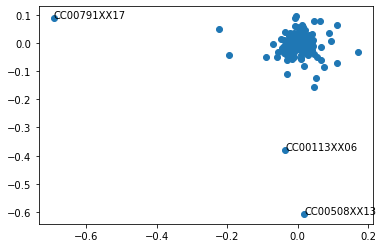

In [103]:
#outlier removal from 2 ancestral principal(?) components.

from scipy import stats

outliers=european_diffusion_dataset_term.index[(np.abs(european_diffusion_dataset_term['Anc_PC2'].agg(stats.zscore))>=3.5)|(np.abs(european_diffusion_dataset_term['Anc_PC3'].agg(stats.zscore))>=3.5)]
# #removing outliers using the ancestrial PCA

fig,ax= plt.subplots()
ax.scatter(european_diffusion_dataset_term.loc[:,'Anc_PC2'],european_diffusion_dataset_term.loc[:,'Anc_PC3'])
for i,txt in enumerate(european_diffusion_dataset_term.loc[outliers,'ID']):
    ax.annotate(txt,(european_diffusion_dataset_term.loc[outliers[i],'Anc_PC2'],european_diffusion_dataset_term.loc[outliers[i],'Anc_PC3']))


In [104]:
#Updated lists to remove the outliers:
european_diffusion_dataset_term.drop(outliers,inplace=True)

In [108]:
#european_diffusion_dataset_term.to_csv('./preprocessed_data/diffusion/term/european_diffusion_dataset_term.csv',index=False)

# IGNORE

## 1.3 Adjusting for covariates (Volumetric)

Text(0, 0.5, 'PC3')

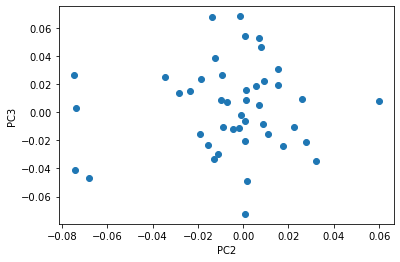

In [90]:
plt.scatter(european_ancestral_PCA[:,1],european_ancestral_PCA[:,2])
plt.xlabel('PC2')
plt.ylabel('PC3')
#check the PC1 vs. PC2, PC2 vs PC3, etc. until I see a structureless blob.

For PRS: I adjusted for the first 3 ancestral PCs.

For volumetric data: I adjusted for age at scan, at birth, intracranial volume, and total volume.

In [91]:
#adjusting for covariates:
#for PRS: I adjusted for 3 PCs. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume (not for connectivity) and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_PRS_schizophrenia=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_PRS_schizophrenia,european_ancestral_PCA[:,0:3])#adjust for the first 3 PCs.
adjusted_european_PRS_schizophrenia=adjusted_european_PRS_schizophrenia.astype('float64')

adjusted_european_volumetric_AAL_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_AAL_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_AAL_matrix=adjusted_european_volumetric_AAL_matrix.astype('float64')

adjusted_european_volumetric_Imperial_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_Imperial_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_Imperial_matrix=adjusted_european_volumetric_Imperial_matrix.astype('float64')

#remove the CSF, Extracranial and Intracranial volume from adjusted_european_volumetric_Imperial_matrix
adjusted_european_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[82,83,84],axis=1)
Imperial_label=np.delete(Imperial_label,[82,83,84],axis=0)

#remove the WM from adjusted_european_structural_schizophrenia
adjusted_european_GM_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=1)
Imperial_GM_labels=np.delete(Imperial_label,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=0)

## 1.3.1 Adjusting covariates (Diffusion)

Text(0, 0.5, 'PC3')

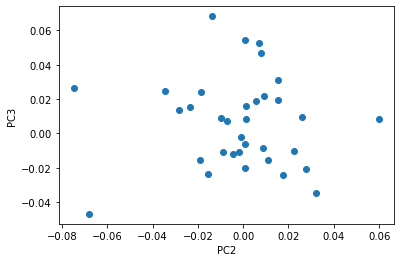

In [33]:
plt.scatter(european_diffusion_ancestral_PCA[:,1],european_diffusion_ancestral_PCA[:,2])
plt.xlabel('PC2')
plt.ylabel('PC3')
#check the PC1 vs. PC2, PC2 vs PC3, etc. until I see a structureless blob.

In [34]:
#adjusting for covariates:
#for PRS: I adjusted for 3 PCs. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume (not for connectivity) and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_diffusion_PRS_schizophrenia=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_diffusion_PRS_schizophrenia,european_diffusion_ancestral_PCA[:,0:3])#adjust for the first 3 PCs.
adjusted_european_diffusion_PRS_schizophrenia=adjusted_european_diffusion_PRS_schizophrenia.astype('float64')

adjusted_european_diffusion_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_diffusion_matrix,european_diffusion_age_at_scan,european_diffusion_gestational_age,european_diffusion_gender)
adjusted_european_diffusion_matrix=adjusted_european_diffusion_matrix.astype('float64')

## 1.4. Saving the processed data (Volumetric)

In [96]:
def name_of_global_obj(xx):
    return [objname for objname, oid in globals().items()
        if id(oid)==id(xx) and not objname.startswith('_')][0]
def save_to_npy(filepath,*args):
    for i in args:
        temp_name=filepath+name_of_global_obj(i)+'.npy'
        np.save(temp_name,i)

In [22]:
# save_to_npy('./preprocessed_data/preterm/',adjusted_european_PRS_schizophrenia,european_PRS_schizophrenia,adjusted_european_volumetric_AAL_matrix,adjusted_european_volumetric_Imperial_matrix,Imperial_GM_labels,adjusted_european_GM_volumetric_Imperial_matrix, AAL_label,european_age_at_scan,european_gestational_age,european_icv)

In [97]:
save_to_npy('./preprocessed_data/volumetric/preterm/',adjusted_european_PRS_schizophrenia,european_PRS_schizophrenia,adjusted_european_volumetric_AAL_matrix,adjusted_european_volumetric_Imperial_matrix,Imperial_GM_labels,adjusted_european_GM_volumetric_Imperial_matrix, AAL_label,european_age_at_scan,european_gestational_age,european_icv)

In [99]:
! ls preprocessed_data/volumetric/preterm/

AAL_label.npy
Imperial_GM_labels.npy
adjusted_european_GM_volumetric_Imperial_matrix.npy
adjusted_european_PRS_schizophrenia.npy
adjusted_european_volumetric_AAL_matrix.npy
adjusted_european_volumetric_Imperial_matrix.npy
european_PRS_schizophrenia.npy
european_age_at_scan.npy
european_gestational_age.npy
european_icv.npy


## 1.4.1 Saving the processed data (Diffusion)

In [25]:
def name_of_global_obj(xx):
    return [objname for objname, oid in globals().items()
        if id(oid)==id(xx) and not objname.startswith('_')][0]
def save_to_npy(filepath,*args):
    for i in args:
        temp_name=filepath+name_of_global_obj(i)+'.npy'
        np.save(temp_name,i)

In [35]:
save_to_npy('./preprocessed_data/diffusion/preterm/',adjusted_european_diffusion_PRS_schizophrenia,adjusted_european_diffusion_matrix,european_diffusion_PRS_schizophrenia,european_diffusion_matrix,european_diffusion_age_at_scan,european_diffusion_gestational_age,european_diffusion_gender)

array(['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R',
       'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L',
       'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R',
       'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L',
       'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R',
       'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L',
       'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R',
       'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R',
       'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R',
       'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R',
       'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L',
       'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R',
       'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L',
       'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R',
       'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R',
   